# High Performance Computing Coursework 1


### Introduction
The object of this assignment is to use matrix multiplication as a medium to explore optimisation of python code through numba's just-in-time compilation feature. Python is a slow language due to in large part to its interpreted nature causing large overhead making processes such as for-loops extra inefficient. Numba essentially compiles the python code into machine code so that the python interpreter can be bypassed. Python is also sequential by nature so the utilization of a for loop over large numbers of iterations can be made much more efficient through the use of parallelisation. I expect that parallelisation will be slower for smaller matricies due to the larger amount of overhead but because the rate of time increase with matrix size increase for series calculations will be larger than that with parallel calculations I expect that after a certain point parallel computations will become more efficient than series computations.

It should be noted that matrix multiplication inherently possesses $O(n^3)$ time complexity so falls under BLAS level 3.

First of all I will display the function slow_matrix_product given in the assignment will begin comparisons to the @ operator.

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit

In [2]:
import numpy as np
from numba import njit, prange, jit

def slow_matrix_product(mat1, mat2):
    """
    Multiply two matrices.
    Inputs:
        mat1 & mat2: The two input matricies to be multiplied.
    Outputs:
        resulting matrix.
    """
    assert mat1.shape[1] == mat2.shape[0]
    result = []
    for c in range(mat2.shape[1]):
        column = []
        for r in range(mat1.shape[0]):
            value = 0
            for i in range(mat1.shape[1]):
                value += mat1[r, i] * mat2[i, c]
            column.append(value)
        result.append(column)
    return np.array(result).transpose()
matrix1 = np.random.rand(10, 10)
matrix2 = np.random.rand(10, 10)

Since numpy stores data in row formatting to optimise memory pulls the transpose of this matrix is initially calculated.

In [46]:
def slow_matrix_product_pre_mem(mat1,mat2):
    """
    Multiply two matricies using the original method but pre allocate memory.
    Inputs:
        mat1 & mat2: The two input matricies to be multiplied.
    Outputs:
        result: product matrix.
    """
    assert mat1.shape[1] == mat2.shape[0]
    
    # Pre-allocate memory for the result matrix
    result = np.zeros((mat1.shape[0], mat2.shape[1]))
    
    for c in range(mat2.shape[1]):
        for r in range(mat1.shape[0]):
            value = 0
            for i in range(mat1.shape[1]):
                value += mat1[r, i] * mat2[i, c]
            result[r, c] = value
            
    return result

I have optimised this function by pre-allocating memory and removing any numpy methods such as self.transpose(). Pre-allocation of memory allows for quicker memory accesses for larger functions as well as optimising this function to work in parallel reduces the co-dependency of each item in the for loop. Removing numpy methods also allows for the addition of the njit decorator as it removes any need to interact with python's interpreter.

In [4]:
slow_list = [slow_matrix_product,slow_matrix_product_pre_mem]

### Reduction to two python for loops:

I have now changed slow_matrix_product to a function with one less loop. This function essentially loops through the rows of the first matrix and the columns of the second matrix and calculates the dot product between the two matrices. np.dot() is used to calculate the dot product between the subsequent row and column matrices. Aternatively the two arrays can be multipled and summed. Although the number of for loops has been reduced making this function have a significantly reduced execution time, it still maintains $O(n^3)$ time complexity but one order is moved inside the C optimised numpy functions. The difference between the two functions below is that as multidimensional arrays are stored in rows, the first function (Faster_Mat_Prod) needs to double index to access an entire column. The function below does not need to do this as it just transposes the second matrix so that the rows can be isolated through single indexing. 

It is important to note that these functions do not yet pre-allocate memory. I have tested the difference between calculating the matrix product with and without transposing below.

In [48]:
def Faster_Mat_Prod(mat1,mat2):
    """
    Multiply two matrices.
    Inputs: mat1, mat2 (multidimentional array)
    Outputs: output matrix array
    """
    assert mat1.shape[1] == mat2.shape[0]
    matrix = []
    for i in range(mat1.shape[0]):
        rows = []
        for j in range(mat2.shape[1]):
            rows.append(np.dot(mat1[i],mat2[:,j]))
        matrix.append(rows)
    return np.array(matrix)
def Faster_Mat_Prod_transpose(mat1,mat2):
    """
    Multiply two matrices by transposing.
    Inputs: mat1, mat2 (multidimentional array)
    Outputs: output matrix array
    """
    assert mat1.shape[1] == mat2.shape[0]
    mat2 = mat2.T
    matrix = []
    for i in range(mat1.shape[0]):
        rows = []
        for j in range(mat2.shape[0]):
            rows.append(np.dot(mat1[i],mat2[j]))
        matrix.append(rows)
    return np.array(matrix)

### Reduction to one python for loop

Below only have one for loop by looping through the rows of the first matrix and then broadcasting the multiplication of that row across the 0 axis (vertically) before summing the result. np.dot achieves the same results more efficiently. This method however also does not reduce time complexity but just moves two orders of time complexity into the numpy functions. This however has a massive increase in speed as most of the loops are carried out in numpy which is highly optimised/vectorised.

In [6]:
def Faster_Mat_Prod_Optimized1(mat1, mat2):
    """Multiply two matrices more efficiently using broadcasting inbuilt into np.sum."""
    assert mat1.shape[1] == mat2.shape[0]
    result = np.zeros((mat1.shape[0], mat2.shape[1])) #pre allocate memory

    for i in range(mat1.shape[0]):
        result[i, :] = np.sum(mat1[i, :, None] * mat2, axis=0) #Use broadcasting

    return result
def Faster_Mat_Prod_Optimized2(mat1, mat2):
    """Multiply two matrices more efficiently using the np.dot function."""
    assert mat1.shape[1] == mat2.shape[0]
    result = np.zeros((mat1.shape[0], mat2.shape[1])) #pre allocate memory

    for i in range(mat1.shape[0]):
        result[i] = np.dot(mat1[i],mat2)  #use np.dot function

    return result
def dot_product(mat1,mat2):
    return mat1 @ mat2


### Testing

Below I have created a function that uses assert statements to make sure that the provided functions provide the same values as for the @ operator. This is tested over a range of different matrix sizes with the 10 as the maximum size each dimension can be.

In [34]:
from numpy.testing import assert_array_almost_equal
def tester(function_list : list, max_size = 10, num = 100):
    mat1s = []
    mat2s = []
    shape1 = []
    shape2 = []
    for i in range(num):
        shared_dimension = np.random.randint(1,max_size + 1)
        mat1s.append(np.random.rand(np.random.randint(1,max_size + 1),shared_dimension))
        mat2s.append(np.random.rand(shared_dimension,np.random.randint(1,max_size + 1)))
        shape1.append(np.array([np.random.randint(1,max_size + 1),shared_dimension]))
        shape2.append(np.array([shared_dimension,np.random.randint(1,max_size + 1)]))
    for func in function_list:
        for i in range(num):
            np.testing.assert_array_almost_equal(func(mat1s[i],mat2s[i]), mat1s[i] @ mat2s[i])
    print("Functions are correctly built if no assertion error raised.")
    return np.array(shape1), np.array(shape2)

In [51]:
shape1,shape2 = tester([slow_matrix_product,slow_matrix_product_pre_mem, Faster_Mat_Prod,Faster_Mat_Prod_transpose,
                        Faster_Mat_Prod_Optimized1, Faster_Mat_Prod_Optimized2])

Functions are correctly built if no assertion error raised.


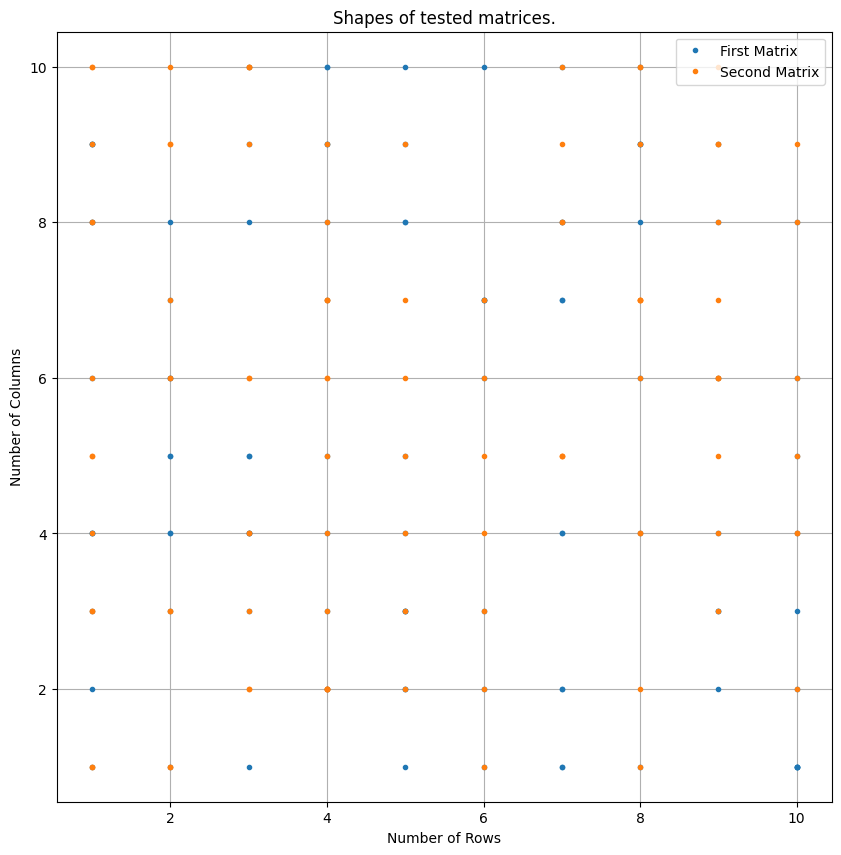

In [52]:
plt.figure(figsize = (10,10))
plt.plot(shape1[:,0],shape1[:,1],'.',label='First Matrix')
plt.plot(shape2[:,0],shape2[:,1],'.',label='Second Matrix')
plt.title('Shapes of tested matrices.')
plt.grid(True)
plt.xlabel('Number of Rows')
plt.ylabel('Number of Columns')
plt.legend(loc='best')

The plot above displays the range of matrix sizes of the first and second matricies the multiplication was validated over showing the general functionality of the functions used for matricies that satisfy the condition: $ A,B \in \mathbb{R}^{m \times n} $. 

### Comparison

I will now build a function that takes multiple functions and compares them to each other through the use of plots. The time taken for a range of different square matrix sizes will be calculated.

In [5]:
def comparison(function_list : list, max_size, no_mat = 10, plot = True, figsize = (6.4,4.8),title ='Performance of Different Functions on Range of Matrix Sizes'):
    """
    inputs:
      function_list - list of functions;
      max_size - maximum size of square matrix;
      no_mat - number of matrices.

      optional - plot:bool; figsize:tuple; title: str.
    outputs:
      None or results: dict and size_array: array - The dict has the name of the function used as the key 
      and contains lists of execution times.
    """
    assert (max_size - 1) % no_mat == 0

    results = {}  #dict to store results and size array of sizes to be tested.
    size_array = np.linspace(2,max_size,no_mat)

    for func in function_list:
        results[func.__name__] = []

    for i in tqdm(size_array):
        size = int(i)
        mat1 = np.random.rand(size,size)  #make square matricies
        mat2 = np.random.rand(size,size)

        for func in function_list:
            Time = %timeit -o -q func(mat1,mat2)
            results[func.__name__].append(Time.best)
    if plot:
        plt.figure(figsize = figsize)
        plt.title(title)
        plt.xlabel('Matrix Size')
        plt.ylabel('Execution Time')
        plt.grid(True)
        for func in function_list:
            plt.plot(size_array,results[func.__name__], label=f'{func.__name__} performance')
        plt.legend(loc='best')
        return None
    else:
        return results, size_array

##### Smaller Matrix Sizes

The below plot shows the difference in performance between matrix sizes at the lower end of the spectrum. This has been done because certain techniques designed to reduced the burden of memory accesses in large matricies might generate an overhead that makes it slower over smaller matricies. The slow matrix product is also extremely slow so we would not be able to differentiate between the other plots at a larger scale.

Note: All below plots with 'Execution Time' in the y-axis are in units of seconds. This has not been added to the plots due to the extremely long run time.

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:26<00:00, 36.33s/it]


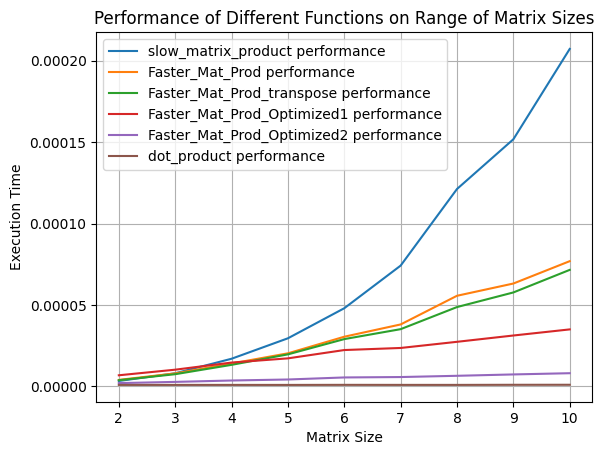

In [13]:
func_list = [slow_matrix_product,Faster_Mat_Prod, Faster_Mat_Prod_transpose,
             Faster_Mat_Prod_Optimized1,Faster_Mat_Prod_Optimized2,dot_product]
comparison(func_list,max_size = 10,no_mat = 9)

Here it can be seen that the slow matrix product appears to be faster than the matrix products that use two for loops and np.sum() as well as the function that uses broadcasting with one for loop (this function is initially the slowest). As we reach the 4X4 matrix the slow_matrix_product function is by far the slowest and followed by the Faster_Mat_Prod functions that use two for loops. Due to the fact that the array stores data by row the matrix multiplication that only uses single indicies (green) through the use of transposition is slightly faster than the one that double indexes the second matrix (orange). For matricies larger than 5 x 5 the Faster_Mat_Prod_Optimized1 function which uses a single for loop with broadcasting becomes the second fastest custom made function due to the vectorisation included in the numpy sum. Below 5x5 the extra overhead to do this slows it down so there is minimal benefit to this. The usage of np.dot() is fastest as it is extremely optimized and does most of the heavy lifting of the matrix product apart from the initial iteration through the rows of the first matrix.

#### Matrix Sizes up to 1000

Below we can see that over large matrix multiplications the slow_matrix_product is much less efficient. This is because the computation time exponentially increases with every added dimension size.

100%|█████████████████████████████████████████████████████| 15/15 [1:50:44<00:00, 443.00s/it]


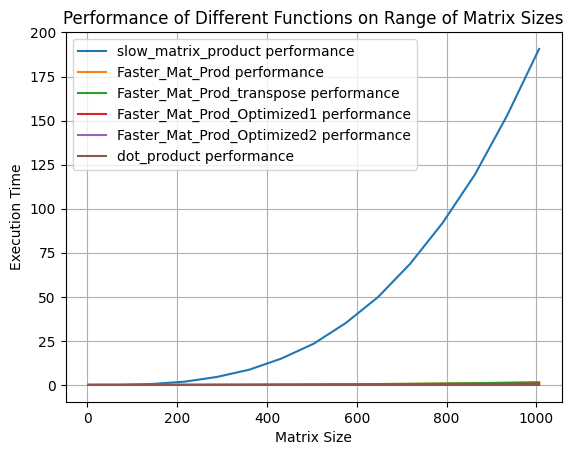

In [14]:
comparison(func_list,max_size = 1006,no_mat = 15)

#### Retesting comparing the different speeds of matrix product

Now the slow matrix product function has been removed so that the other functions can be compared with larger matricies. The performance difference between the transposed and non transposed functions Faster_Mat_Prod and Faster_Mat_Prod_transpose still remains small whilst the other differences mentioned before have become more apparent due to the exponential increase mentioned before. The difference between the @ operator and the Faster_Mat_Prod_Optimized2 function remains relatively small due to how much of the calculation np.dot() does.

100%|████████████████████████████████████████████████████████| 15/15 [07:41<00:00, 30.79s/it]


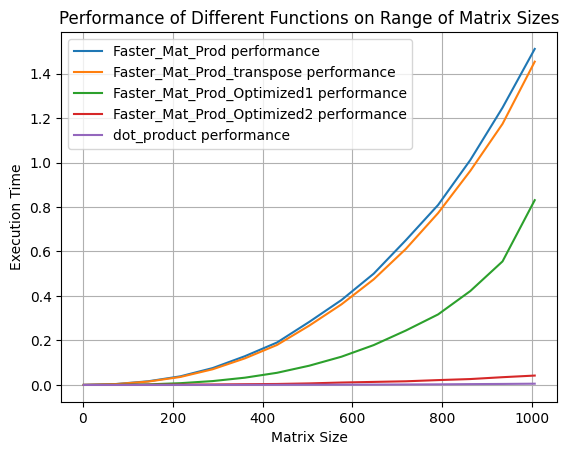

In [15]:
comparison(reduced_func_list, max_size = 1006, no_mat = 15)

### Pre-allocation of memory

Below the slight speed up caused by the pre-allocation of memory has been measured although it is evident that the difference is relatively small. The reason why the pre-allocation of memory causes a speed up is that in numpy arrays the information is stored in consecutive memory addresses however in lists the location is more random. This means that appending lists will be slower as memory accesses will be further apart however this appears to have minimal contribution to total speed.

100%|██████████████████████████████████████████████████████████| 9/9 [01:54<00:00, 12.76s/it]


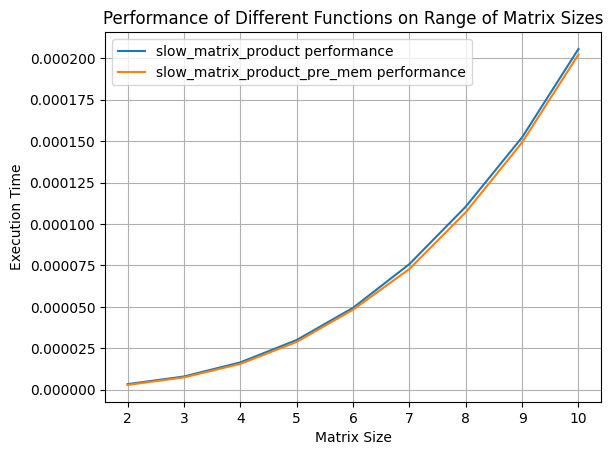

In [23]:
comparison(slow_list,max_size = 10,no_mat = 9)

## Acceleration using Numba

I will first analyse performance on a the slow matrix product function that has been just in time compiled with jit. No memory is pre allocated and it functions through populating rows of data which are then appended to the output two dimensional array before being transposed so that the rows become columns. The first matrix has been compiled using jit as it uses the self.transpose() numpy method that appears to access the python interpreter meaning that njit or jit(nopython=True) is not possible.

I have decided to use the functions based off slow_matrix_product first for numba acceleration because they use more pure python code and are slower so the numba speed up should be more visible.

In [115]:
@jit()
def numba_slow_matrix_product(mat1, mat2):
    """Multiply two matrices. No memory is pre allocated here."""
    assert mat1.shape[1] == mat2.shape[0]
    result = []
    for c in range(mat2.shape[1]):
        column = []
        for r in range(mat1.shape[0]):
            value = 0
            for i in range(mat1.shape[1]):
                value += mat1[r, i] * mat2[i, c]
            column.append(value)
        result.append(column)
    return np.array(result).transpose()
@njit()
def numba_slow_matrix_product_njit(mat1, mat2):
    """
    This is the same as the original slow matrix product except it utilises njit instead of jit
    """
    assert mat1.shape[1] == mat2.shape[0]
    result = []
    for r in range(mat1.shape[0]):
        row = []
        for c in range(mat2.shape[1]):
            value = 0
            for i in range(mat1.shape[1]):
                value += mat1[r,i] * mat2[i,c]
            row.append(value)
        result.append(row)
    return result  #### should be np.array(result) but njit does not support 

/tmp/ipykernel_407/2626059306.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [03:23<00:00, 13.59s/it]


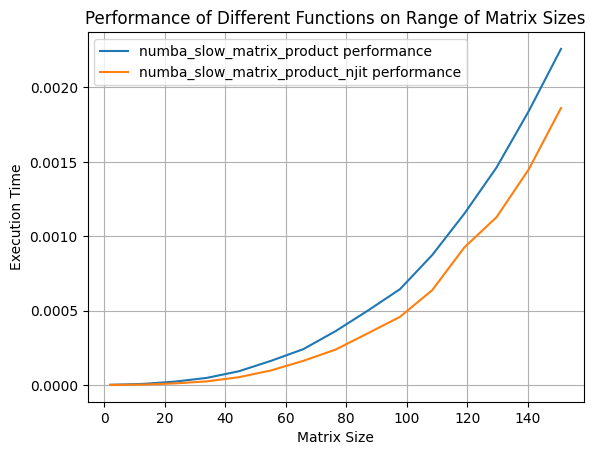

In [54]:
comparison([numba_slow_matrix_product,numba_slow_matrix_product_njit], max_size = 151, no_mat = 15)

100%|████████████████████████████████████████████████████████| 15/15 [02:34<00:00, 10.31s/it]


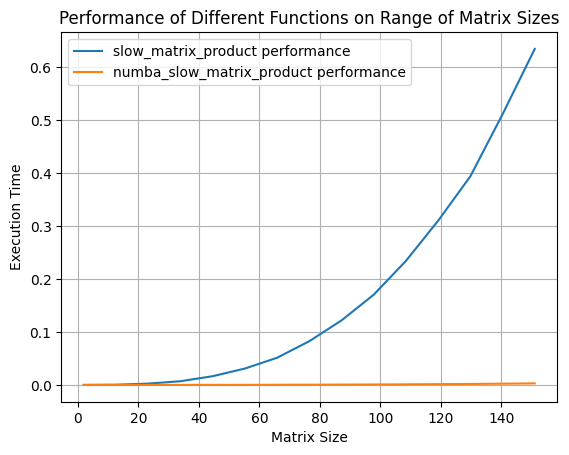

In [55]:
comparison([slow_matrix_product,numba_slow_matrix_product], max_size = 151, no_mat = 15)

The two plots shown above show that numba significantly accelerates the slow matrix product computation and that forbidding the just in time compiler to completely ignore the interpreter through the njit decorator offers a noticeable speedup.

In [117]:
@njit()
def numba_slow_matrix_product_premem(mat1, mat2):
    """Multiply two matrices. Memory pre-allocated although still in series."""
    assert mat1.shape[1] == mat2.shape[0]
    
    # Pre-allocate memory for the result matrix
    result = np.zeros((mat1.shape[0], mat2.shape[1]))
    
    for c in range(mat2.shape[1]):
        for r in range(mat1.shape[0]):
            value = 0
            for i in range(mat1.shape[1]):
                value += mat1[r, i] * mat2[i, c]
            result[r, c] = value
    return result

In [118]:
@njit(parallel=True)
def numba_slow_matrix_product_parallel(mat1, mat2):
    """Multiply two matrices. For parallelization memory pre-allocated."""
    assert mat1.shape[1] == mat2.shape[0]
    
    # Pre-allocate memory for the result matrix
    result = np.zeros((mat1.shape[0], mat2.shape[1]))
    
    for c in prange(mat2.shape[1]):
        for r in range(mat1.shape[0]):
            value = 0
            for i in range(mat1.shape[1]):
                value += mat1[r, i] * mat2[i, c]
            result[r, c] = value
    return result

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [04:14<00:00, 25.45s/it]


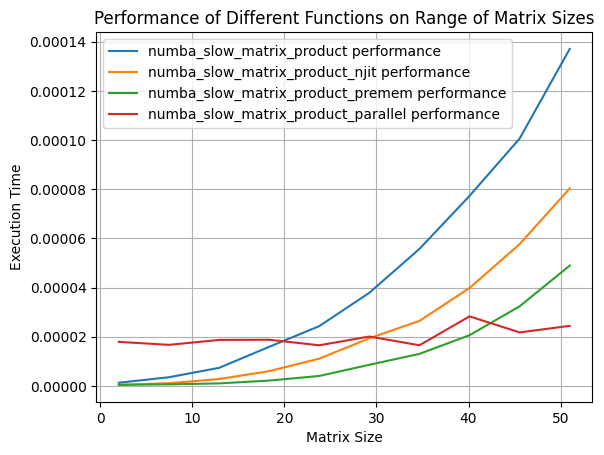

In [121]:
comparison([numba_slow_matrix_product,numba_slow_matrix_product_njit,numba_slow_matrix_product_premem,numba_slow_matrix_product_parallel],max_size = 51,no_mat = 10)

Above it appears that the parallelised function initially underperforms compared to the series function that still pre-allocates memory. This can be explained by the extra initial overhead when the operation is parallelised outweighing the increased performance with matricies this small. It is also clear to see that pre-allocating memory so that the memory addresses are closer to each other benefits performance much more when numba is used to compile the code. It can be seen that after around the 42x42 matrix size point the benefits of parallelisation become aparent and outweigh the initial upgront memory cost.

Below the parallel vs series performance can be seen up to the 1000x1000 size matrix where the parallelised matrix massively outperforms the series one.

100%|████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.12s/it]


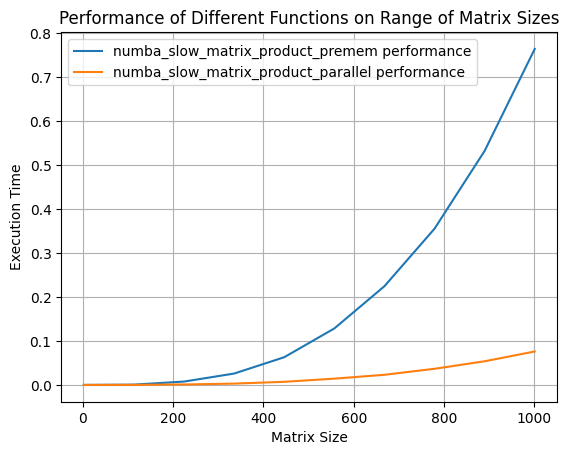

In [40]:
comparison([numba_slow_matrix_product_premem,numba_slow_matrix_product_parallel], max_size = 1001, no_mat = 10)

## Testing Numba on faster matrix multiplication functions

As the most highly optimized matricies mostly use np.dot or the broadcasted np.sum() so that only one for loop is required, I will use numba on the faster function that only utilises on for loop.

In [15]:
@njit()
def numba_Faster_Mat_Prod(mat1,mat2):
    """
    Multiply two matrices. Uses two for loops and np.sum() functions.
    Inputs: mat1, mat2 (multidimentional array)
    Outputs: output matrix array
    """
    assert mat1.shape[1] == mat2.shape[0]
    
    # Pre-allocate memory for the result matrix
    matrix = np.zeros((mat1.shape[0], mat2.shape[1]))
    
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[1]):
            matrix[i, j] = np.sum(mat1[i]* mat2[:, j])
            
    return matrix

In [123]:
@njit(parallel=True)
def numba_parallel_Faster_Mat_Prod(mat1,mat2):
    """
    Multiply two matrices. Uses two for loops and np.sum() with numba in parallel.
    Inputs: mat1, mat2 (multidimentional array)
    Outputs: output matrix array
    """
    assert mat1.shape[1] == mat2.shape[0]
    
    # Pre-allocate memory for the result matrix
    matrix = np.zeros((mat1.shape[0], mat2.shape[1]))
    
    for i in prange(mat1.shape[0]): #parallel for loop
        for j in range(mat2.shape[1]):
            matrix[i, j] = np.sum(mat1[i]* mat2[:, j])
            
    return matrix

100%|████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.86s/it]


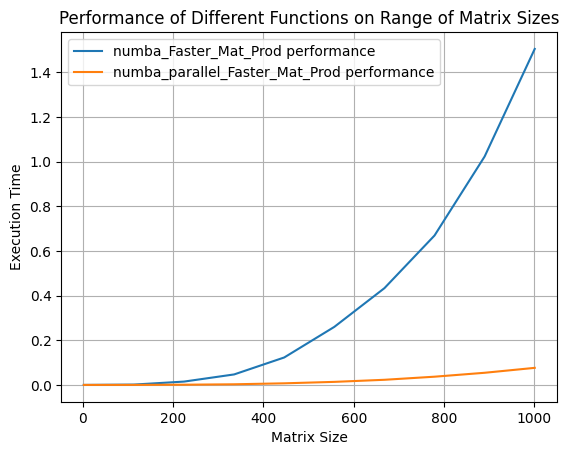

In [50]:
comparison([numba_Faster_Mat_Prod,numba_parallel_Faster_Mat_Prod], max_size = 1001, no_mat = 10)

It can be seen that the numba_Faster_Mat_Prod function that runs in series is slightly slower than the numba accelerated slow_matrix_product function with memory preallocated. This is because numba accelerates the code to be similar speed to that of numpy but numpy itself is already in C/C++ so does not get accelerated. The inclusion of numpy functions also reduced the chance that njit can be used. The numba parallel implementation of this function appears to be more similar to the numba_slow_matrix_product_parallel function.

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.64s/it]


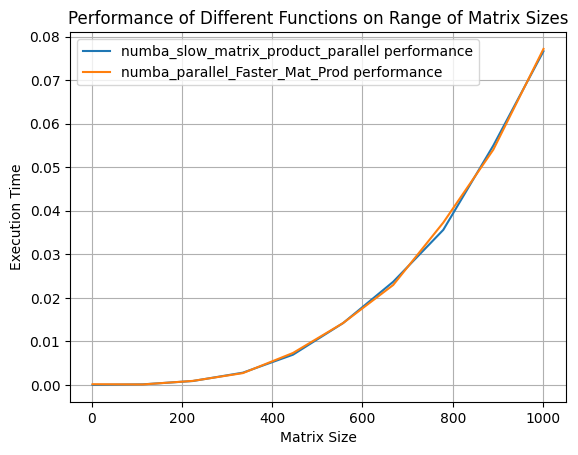

In [124]:
comparison([numba_slow_matrix_product_parallel,numba_parallel_Faster_Mat_Prod], max_size = 1001, no_mat = 10)

## Utilization of numba on matrix multiplication using single for loop

In [21]:
@jit(parallel=True)
def numba_Faster_Mat_Prod_Optimized(mat1, mat2):
    """Multiply two matrices more efficiently."""
    assert mat1.shape[1] == mat2.shape[0]
    result = np.zeros((mat1.shape[0], mat2.shape[1])) #pre allocate memory
    #parallel for loop
    for i in prange(mat1.shape[0]):
        result[i] = np.dot(mat1[i],mat2)

    return result

@jit()
def numba_series_Faster_Mat_Prod_Optimized(mat1, mat2):
    """Multiply two matrices more efficiently."""
    assert mat1.shape[1] == mat2.shape[0]
    result = np.zeros((mat1.shape[0], mat2.shape[1])) #pre allocate memory

    for i in range(mat1.shape[0]):
        result[i] = np.dot(mat1[i],mat2)

    return result
@jit()
def jit_broadcast_oneloop(mat1,mat2):
    """Multiply two matrices more efficiently using broadcasting inbuilt into np.sum."""
    assert mat1.shape[1] == mat2.shape[0]
    result = np.zeros((mat1.shape[0], mat2.shape[1])) #pre allocate memory

    for i in range(mat1.shape[0]):
        result[i, :] = np.sum(mat1[i, :, None] * mat2, axis=0) #Use broadcasting

    return result

/tmp/ipykernel_411/580943016.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True)
/tmp/ipykernel_411/580943016.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/tmp/ipykernel_411/580943016.py:22: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for thi

100%|████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.75s/it]


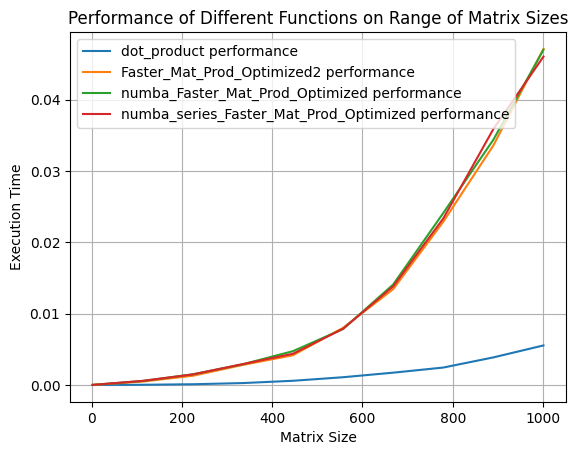

In [77]:
comparison([dot_product,Faster_Mat_Prod_Optimized2,numba_Faster_Mat_Prod_Optimized,numba_series_Faster_Mat_Prod_Optimized], max_size = 1001, no_mat = 10)

It can be seen here that the more the functions I make depend on the numpy functions that allow for efficient array handling, the less the benefits I see from using numba. It can be seen here that when np.dot() is used in a single for loop there is very little difference between the series and parallel implementations of numba vs the original function. A cause of this could be that the numpy implementations are so optimized that the use of numba on a single for loop barely makes a difference. Numba also converts pure python to machine code and since nopython mode is not enabled it skips the complicated numpy functions. I will now test this for a much larger function. The @ operator is proven to be the most efficient as it has superior optimization.

This aligns with my earlier hypothesis that using numba would be more beneficial with functions that have more pure python instead of relying on numpy vectorisation.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [27:33<00:00, 165.34s/it]


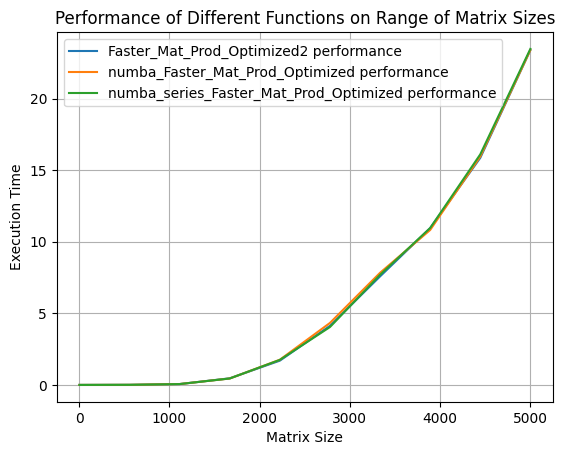

In [20]:
comparison([Faster_Mat_Prod_Optimized2,numba_Faster_Mat_Prod_Optimized,numba_series_Faster_Mat_Prod_Optimized], max_size = 5001, no_mat = 10)

Increasing the size of the matricies being multiplied to 5000, we can see that using numba acceleration does not make a difference to the speed of the the matrix calculation as the np.dot operation is already extremely optimized.

Here numba_Faster_Mat_Prod_Optimized uses parallelisation techniques and np.dot() and numba_series_Faster_Mat_Prod_Optimized pre allocates memory and used np.dot().

It can be seen below that using numba can slightly accelerate the numpy.sum() broadcasting process when for loop is utilised but larger matricies are required to truly see the performance difference.

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.92s/it]


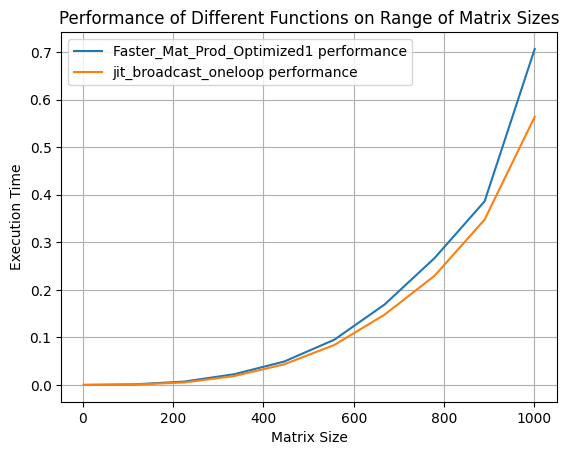

In [23]:
comparison([Faster_Mat_Prod_Optimized1,jit_broadcast_oneloop], max_size = 1001, no_mat = 10)

In [55]:
%%time
numba_series_Faster_Mat_Prod_Optimized(matrix1,matrix2)

CPU times: user 487 µs, sys: 52 µs, total: 539 µs
Wall time: 411 µs


array([[2.72797532, 3.65383092, 3.71197609, 2.36411502, 2.52369552,
        2.23327143, 3.68295709, 2.97229625, 2.7826717 , 4.02685146],
       [1.54166273, 2.65126811, 2.14198283, 1.240974  , 1.21332264,
        1.50393019, 2.49511092, 2.51360905, 1.54563867, 2.67359082],
       [2.4523526 , 2.95845143, 2.52756437, 1.49518437, 1.55440036,
        2.15268917, 3.05740099, 2.6002151 , 2.20061165, 3.0614243 ],
       [1.95771336, 2.545597  , 2.25365908, 1.42632166, 1.70301143,
        2.05603456, 2.15761572, 2.03413167, 2.41111826, 2.72137812],
       [2.20326588, 2.67436868, 2.59229647, 1.66090381, 1.63824136,
        1.94236725, 2.88076898, 2.15694493, 2.26111309, 2.94018647],
       [2.74647565, 3.51683296, 3.25247476, 1.72678616, 1.91647172,
        2.45925721, 3.35273771, 2.83083532, 2.73218159, 3.77145824],
       [2.17646757, 2.63455052, 2.80900675, 1.64427071, 1.37983333,
        1.67633664, 2.97910581, 2.03781001, 1.99051555, 3.11429553],
       [3.27241159, 3.83745154, 3.8530132

### Fortran vs C array format

I will begin by editing the previous comparison() function I made so that one of the inputs it takes is the format of the array. I will then test the performance of changing the memory layout of the array with the numba functions.

Fortran uses column based memory storage for matricies and C uses row based memory organisation.

In [6]:
def comparison_FORTRAN(function_list : list, max_size, no_mat = 10,fortran = False, plot = True, figsize = (6.4,4.8),title ='Performance of Different Functions on Range of Matrix Sizes'):
    """
    inputs:
      function_list: list of functions;
      max_size: maximum size of square matrix;
      no_mat: number of matrices.
    """
    assert (max_size - 1) % no_mat == 0

    #dictionary with function names as keys and the times taken as lists.
    results = {}
    size_array = np.linspace(2,max_size,no_mat)
    if fortran:
        execution_order = [('C','C'),('C','F'),('F','C'),('F','F')]  #determines memory layout of input
    else:    
        execution_order = [('C','C')]
    
    def nothing(input): #function to keep C mapping
        return input
    map = {'C':nothing,'F':np.asfortranarray}
    for func in function_list:
        for o in execution_order:
            results[func.__name__ + f' {o}'] = []

    for i in tqdm(size_array):  #iterate in array sizes, then functions then execution order
        size = int(i)
        for func in function_list:
            for o in execution_order:
                mat1 = map[o[0]](np.random.rand(size,size))  #converts data if in correct order
                mat2 = map[o[1]](np.random.rand(size,size))
                Time = %timeit -o -q func(mat1,mat2)
                results[func.__name__ + f' {o}'].append(Time.best)
    if plot:
        plt.figure(figsize = figsize)
        plt.title(title)
        plt.xlabel('Matrix Size')
        plt.ylabel('Execution Time')
        plt.grid(True)
        for name in results.keys():  #changed label to keys in dict to separate fortran from C
            plt.plot(size_array,results[name], label=name)
        plt.legend(loc='best')
        return None
    else:
        return results, size_array

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [04:17<00:00, 25.73s/it]


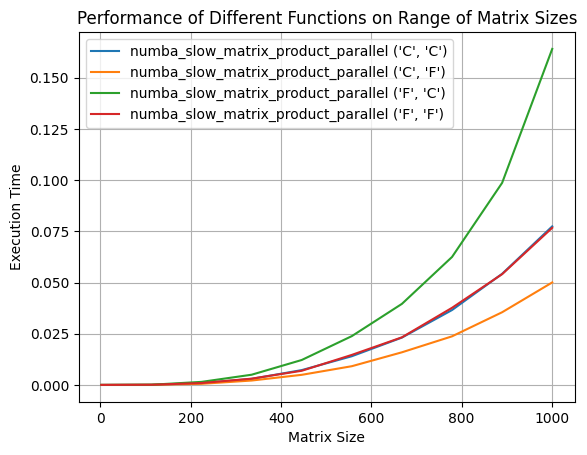

In [29]:
comparison_FORTRAN([numba_slow_matrix_product_parallel], max_size = 1001, no_mat = 10,fortran = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.77s/it]


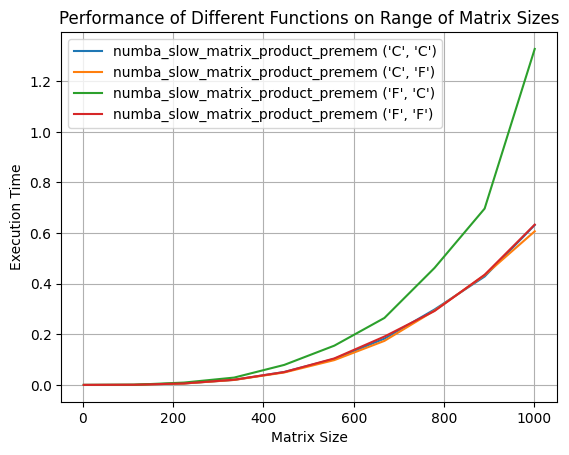

In [35]:
comparison_FORTRAN([numba_slow_matrix_product_premem], max_size = 1001, no_mat = 10,fortran = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [04:10<00:00, 25.02s/it]


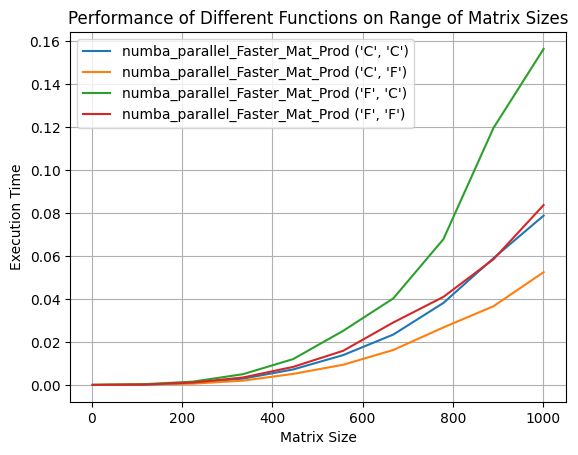

In [30]:
comparison_FORTRAN([numba_parallel_Faster_Mat_Prod], max_size = 1001, no_mat = 10, fortran = True)

It can be seen that when the memory layout of the matricies are both Fortran or C style the functions perform similarly. When the memory layout of the first matrix is C stlye and the second is Fortran style the performance is the fastest and the performance is slowest when the memory layout of the first matrix is Fortran stlye and the memory layout of the second is C style. When looking at the theory this makes a lot of sense.

Essentially the  functions that are used essentially include three main loops. The outer loop is to loop through the columns of the second matrix, the second is to loop through the rows of the first matrix and the inner loop is designed to loop through the selected row in the first matrix and the selected column in the second matrix. np.sum() allows the inner loop to be foregone. 

The C memory layout has row-major ordering and the Fortran memory layout has column major ordering. At first glance this seems optimal as in matrix multiplication the scalar product between the rows of the first matrix and the columns of the second matrix is found.

In modern CPUs, memory accesses from the cache are faster than accessing from main memory. This means that when data is accessed sequentially, if the data pulls are not cache friendly (memory accesses are far from each other), performance will suffer. This explains why  the numba_slow_matrix_product_premem function that used numba to accelerate the function in series suffered with the Fortran - C order whilst remaining the same with the others. It can be assumed that the other combinations all allowed memory pulls to be made using the cache.

Now looking at the performance of the parallelised functions, the layout with the C style memory layout for the first matrix and the Fortran style memory layout for the second matrix really begins to show its merits. Consecutive memory accesses are faster the closer that the memory addresses are especially in parallel when multiple operations are processed with a single operation. If multiple rows of the first matrix are being multiplied against multiple columns of the second matrix, the first matrix having C style ordering and the second having Fortran stlye ordering allows the chunks of data that are consecutively accessed to have closer addresses.

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [04:03<00:00, 24.30s/it]


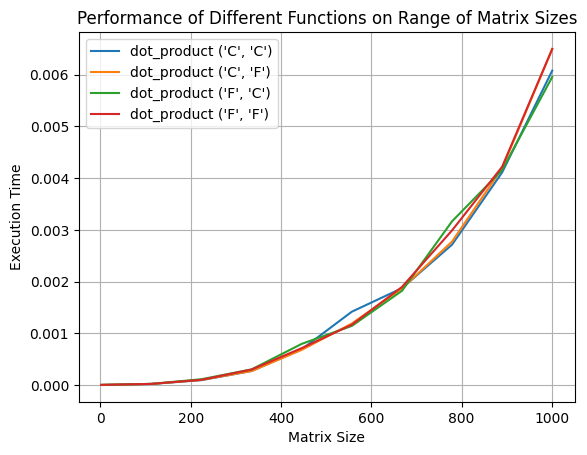

In [31]:
comparison_FORTRAN([dot_product], max_size = 1001, no_mat = 10, fortran = True)

As we can see the premade dot product "@" operator is so optimized that there isn't much difference between the different memory orderings.

## Extra Notes:

So far these previous functions have been created for matricies that satisfy the group $ A,B \in \mathbb{R}^{m \times n} $ but have mostly been tested on functions that satisfy the $ A,B \in \mathbb{R}^{n \times n} $ condition. The method of matrix multiplication I have used so far is called a naive matrix multiplication but for matricies of larger sizes it might make sense to use the block matrix approach which is simple if we assume square matricies. The way this works is by having a matrix A that has elements such as $A_{ab}$ split into sub matricies with structure $A_{\alpha\beta}$. To transfer between these coordinate frames you can use the following transformations:

* From Large Matrix to Blocks: round down $\frac{a}{M}$ and $\frac{b}{M}$ to get the row and column block coordinates respectively. a mod M and b mod M should return the coordinates within the specific block. Here M is the size of the square matrix

* From Blocks to Large Matricies: $a = \alpha \times M + n$ and $b = \beta \times M + m$.

This method would be worth exploring but I predict that it would prove more usefull over larger matricies that have not been tested. A function to test this would look like the one displayed below.

In [28]:
def optimal_block_size(N):
    """
    optimises block size. (Extremely inefficient)
    """
    # From sqrt(N), find the closest divisor
    for size in range(int(np.sqrt(N)), 0, -1):
        if N % size == 0:
            return size
@jit(parallel=True) #used block worker to minimise interaction with python interpreter.
def block_worker_njit(block_size,num_blocks,A,B,C):
    for i in range(num_blocks):
        for j in range(num_blocks):
            for k in range(num_blocks):
                # Calculate block indices
                row_start_A = i * block_size
                row_end_A = (i + 1) * block_size
                col_start_B = j * block_size
                col_end_B = (j + 1) * block_size
                row_start_B = k * block_size
                row_end_B = (k + 1) * block_size
                
                # Extract blocks from A and B
                A_block = A[row_start_A:row_end_A, row_start_B:row_end_B]
                B_block = B[row_start_B:row_end_B, col_start_B:col_end_B]
                
                # Multiply and accumulate
                C[row_start_A:row_end_A, col_start_B:col_end_B] += np.dot(A_block, B_block)
    return C

def block_matrix_multiply(A, B):
    """
    Multiply square matrices A and B using block matrix multiplication with automatically determined block size.
    """
    
    # Check if the matrices are square and of the same size
    if A.shape[0] != A.shape[1] or B.shape[0] != B.shape[1] or A.shape[0] != B.shape[0]:
        raise ValueError("Both A and B should be square matrices of the same size.")
    
    # Determine the optimal block size
    N = A.shape[0]
    block_size = optimal_block_size(N)
    
    # Initialize the result matrix
    C = np.zeros((N, N))
    
    # Calculate number of blocks
    num_blocks = N // block_size
    
    return block_worker_njit(block_size,num_blocks,A,B,C)

/tmp/ipykernel_407/1743466850.py:17: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True)


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:05<00:00, 73.04s/it]


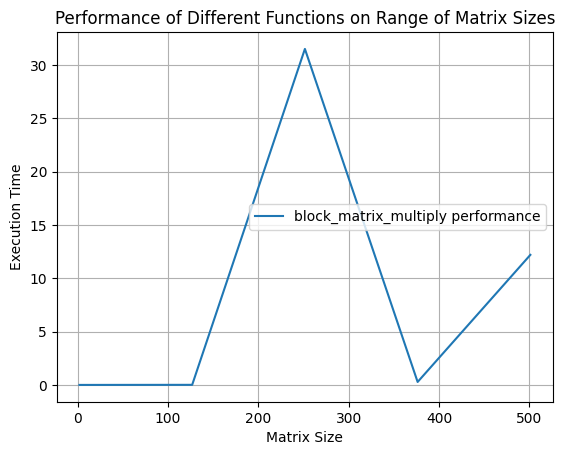

In [33]:
comparison([block_matrix_multiply], max_size = 501, no_mat = 5)

It appears that there is a lot of variance so this plot isn't very useful. This can be explained by the extremely inefficient optimization function making this approach very difficult to test automatically with the varying time of convergence on an optimal block size being the primary botleneck. Below I will do four quick tests with the blocksize hardcoded.

In [3]:
@jit(parallel=True) #used block worker to minimise interaction with python interpreter.
def block_worker_njit(block_size,num_blocks,A,B,C):
    """
    Worker function that contains for loops. This is so the jit decorator is used on python code 
    that is as pure as possible.
    """
    for i in prange(num_blocks):
        for j in range(num_blocks):
            for k in range(num_blocks):
                # Calculate block indices
                row_start_A = i * block_size
                row_end_A = (i + 1) * block_size
                col_start_B = j * block_size
                col_end_B = (j + 1) * block_size
                row_start_B = k * block_size
                row_end_B = (k + 1) * block_size
                
                # Extract blocks from A and B
                A_block = A[row_start_A:row_end_A, row_start_B:row_end_B]
                B_block = B[row_start_B:row_end_B, col_start_B:col_end_B]
                
                # Multiply and accumulate
                C[row_start_A:row_end_A, col_start_B:col_end_B] += np.dot(A_block, B_block)
    return C

def block_matrix_multiply(A, B,block_size):
    """
    Multiply square matrices A and B using block matrix multiplication with automatically determined block size.
    """
    
    # Check if the matrices are square and of the same size
    if A.shape[0] != A.shape[1] or B.shape[0] != B.shape[1] or A.shape[0] != B.shape[0]:
        raise ValueError("Both A and B should be square matrices of the same size.")
    
    # Determine the optimal block size
    N = A.shape[0]
    if N % block_size != 0:
        raise ValueError("The block size must be a divisor of the size of A and B.")
    # Initialize the result matrix
    C = np.zeros((N, N))
    
    # Calculate number of blocks
    num_blocks = N // block_size
    
    return block_worker_njit(block_size,num_blocks,A,B,C)

/tmp/ipykernel_3464/3028412105.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True) #used block worker to minimise interaction with python interpreter.


In [96]:
matrix1 = np.random.rand(10,10)
matrix2 = np.random.rand(10,10)
block_size = 2


T = %timeit -o -q block_matrix_multiply(matrix1,matrix2,block_size)
print(T.best)

0.00031869710300088625


In [97]:

matrix1 = np.random.rand(100,100)
matrix2 = np.random.rand(100,100)
block_size = 20

T = %timeit -o -q block_matrix_multiply(matrix1,matrix2,block_size)
print(T.best)

0.0004651767590003146


In [98]:

matrix1 = np.random.rand(1000,1000)
matrix2 = np.random.rand(1000,1000)
block_size = 200

T = %timeit -o -q block_matrix_multiply(matrix1,matrix2,block_size)
print(T.best)

0.04339319720002095


In [99]:
matrix1 = np.random.rand(5000,5000)
matrix2 = np.random.rand(5000,5000)
block_size = 1000

T = %timeit -o -q block_matrix_multiply(matrix1,matrix2,block_size)
print(T.best)

1.427586126001188


In [106]:
5000/1500

3.3333333333333335

In [107]:
blocksizes = [200,500,1000,1250,2500]

ts = []
for i in blocksizes:
    Time = %timeit -o -q block_matrix_multiply(matrix1,matrix2,i)
    ts.append(Time.best)

Text(0, 0.5, 'computational time')

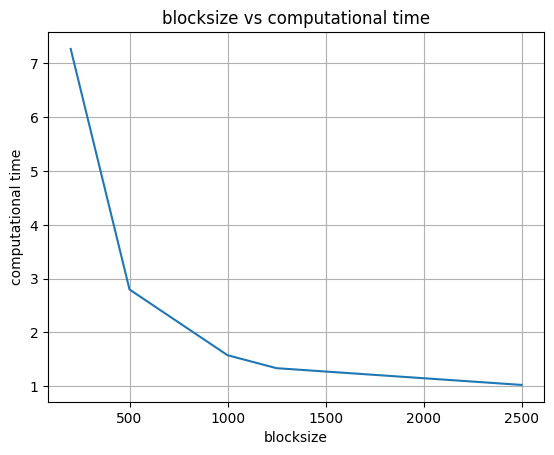

In [108]:
plt.figure()
plt.plot(blocksizes,ts)
plt.title('blocksize vs computational time')
plt.grid(True)
plt.xlabel('blocksize')
plt.ylabel('computational time')

In [110]:
matrix1 = np.random.rand(5000,5000)
matrix2 = np.random.rand(5000,5000)
block_size = 1250
T = %timeit -o -q block_matrix_multiply(matrix1,matrix2,block_size)
print(T.best)

1.4091732389988465


In [111]:
matrix1 = np.random.rand(5000,5000)
matrix2 = np.random.rand(5000,5000)
block_size = 2500
T = %timeit -o -q block_matrix_multiply(matrix1,matrix2,block_size)
print(T.best)

1.0481669199998578


In [112]:
#### now for the one for loop function that is optimised with np.dot()
matrix1 = np.random.rand(5000,5000)
matrix2 = np.random.rand(5000,5000)
T = %timeit -o -q Faster_Mat_Prod_Optimized2(matrix1,matrix2)
print(T.best)

26.022011463001036


In [113]:
T = %timeit -o -q dot_product(matrix1,matrix2)
print(T.best)

0.6541763349996472


In [7]:
matrix1 = np.random.rand(5000,5000)
matrix2 = np.random.rand(5000,5000)
block_size = 2500
np.allclose(block_matrix_multiply(matrix1,matrix2,block_size),dot_product(matrix1,matrix2))

True

Over extremely large matricies it appears that the block matrix approach is most efficient as opposed to the single for loop function that utilises dot product.